In [15]:
import sys, pathlib

PROJECT_ROOT = pathlib.Path.cwd().parents[0]  
if PROJECT_ROOT not in map(pathlib.Path, sys.path):
    sys.path.append(str(PROJECT_ROOT))


In [16]:
import numpy as np
import pandas as pd
import scipy.linalg as la

from scipy.linalg import norm as linalg_norm
from scipy.stats import norm as stats_norm, gamma
from scipy import stats
from functions.lib_fun import *  
from functions.MAVE1 import *

from functions.gram_matrix import *
from functions.FOPG import *

from scipy.linalg import sqrtm
from numpy.linalg import inv
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLassoCV

In [17]:
X = pd.read_csv('bikex.csv',header=None)
Y = pd.read_csv('bikey.csv',header=None)
X = X.to_numpy()
Y = Y.to_numpy()

row_sums = Y.sum(axis = 1,keepdims = True)
Y1 = Y/row_sums

metric = "Wasserstein"
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X = X_normalized
n,p = X.shape
neigh = False
d_0 = 2

In [18]:
#GWIRE
Nb = []
    
if not neigh:
    # Neighborhood is unknown
    graphical_lasso_model = GraphicalLassoCV() 
    graphical_lasso_model.fit(X)
    omega = graphical_lasso_model.precision_
        
for j in range(p):
    Ni = np.nonzero(omega[j, :])[0].tolist()
    Nb.append(Ni)

beta_gwire, _ = gwire_cv(X, Y, Nb, metric, d_0, fold=5)

Xb = X@beta_gwire
df = pd.DataFrame(Xb)
df.to_csv('bikeGx.csv', index=False)
X2 = np.hstack((Xb, np.ones((n, 1))))

y_pred = np.dot(X2, np.linalg.inv(np.dot(X2.T, X2)).dot(X2.T).dot(Y))

SS_res = np.sum((Y - y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y,axis=0))**2)
R_squared1 = 1 - (SS_res / SS_tot)

# Calculate adjusted R-squared
R_squared_adj = 1 - ((1 - R_squared1) * (n - 1) / (n - p - 1))

# Display the results
print(f'R-squared: {R_squared1}')
print(f'Adjusted R-squared: {R_squared_adj}')


#poly fit

Xpoly = np.hstack([
    np.ones((n, 1)),                
    Xb,                             
    Xb**2,                            
    Xb[:, [0]] * Xb[:, [1]],          
     
])


Xpoly_inv = inv(Xpoly.T @ Xpoly)
y_pred = Xpoly @ Xpoly_inv @ Xpoly.T @ Y

# Calculate R-squared
SS_res = np.sum((Y - y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y))**2)
R_squared1 = 1 - (SS_res / SS_tot)

print(f'Poly_R-squared: {R_squared1}')

R-squared: 0.5079412538178087
Adjusted R-squared: 0.5038577787457574
Poly_R-squared: 0.768584875774197


In [19]:

ygram = gram_matrix2(Y1,1)
beta_fopg =FOPG(X,ygram,d_0)
Xb = X@beta_fopg
df = pd.DataFrame(Xb)
df.to_csv('bikeFx.csv', index=False)
X2 = np.hstack((Xb, np.ones((n, 1))))

y_pred = np.dot(X2, np.linalg.inv(np.dot(X2.T, X2)).dot(X2.T).dot(Y))

SS_res = np.sum((Y - y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y,axis=0))**2)
R_squared1 = 1 - (SS_res / SS_tot)

# Calculate adjusted R-squared
R_squared_adj = 1 - ((1 - R_squared1) * (n - 1) / (n - p - 1))

# Display the results
print(f'R-squared: {R_squared1}')
print(f'Adjusted R-squared: {R_squared_adj}')


#poly fit

Xpoly = np.hstack([
    np.ones((n, 1)),                
    Xb,                             
    Xb**2,                            
    Xb[:, [0]] * Xb[:, [1]],          
     
])


Xpoly_inv = inv(Xpoly.T @ Xpoly)
y_pred = Xpoly @ Xpoly_inv @ Xpoly.T @ Y

# Calculate R-squared
SS_res = np.sum((Y - y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y))**2)
R_squared1 = 1 - (SS_res / SS_tot)

print(f'Poly_R-squared: {R_squared1}')

R-squared: 0.3659035895027093
Adjusted R-squared: 0.360641378627213
Poly_R-squared: 0.7039367377728486


In [20]:
#Fd_SDR
ygram2 = gram_matrix2(Y,10)
ygram2 = np.real(sqrtm(ygram2))
init = beta_fopg
beta_dcov, _,_ = MAVE1(X.T,ygram2,init)

Xb = X@beta_dcov
df = pd.DataFrame(Xb)
df.to_csv('bikeDx.csv', index=False)
X2 = np.hstack((Xb, np.ones((n, 1))))
y_pred = X2@ inv((X2.T@ X2))@(X2.T)@(Y)

SS_res = np.sum((Y - y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y,axis=0))**2)
R_squared1 = 1 - (SS_res / SS_tot)

# Calculate adjusted R-squared
R_squared_adj = 1 - ((1 - R_squared1) * (n - 1) / (n - p - 1))

# Display the results
print(f'R-squared: {R_squared1}')
print(f'Adjusted R-squared: {R_squared_adj}')




# Extend the feature matrix X
Xpoly = np.hstack([
    np.ones((n, 1)),                # Column of ones
    Xb,                              # Original features
    Xb**2,                            # Squares of the features
    Xb[:, [0]] * Xb[:, [1]],           # Interaction terms
     
])

# Prediction using polynomial regression
Xpoly_inv = inv(Xpoly.T @ Xpoly)
y_pred = Xpoly @ Xpoly_inv @ Xpoly.T @ Y

# Calculate R-squared
SS_res = np.sum((Y - y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y))**2)
R_squared1 = 1 - (SS_res / SS_tot)

print(f'Poly_R-squared: {R_squared1}')


R-squared: 0.5229244997065465
Adjusted R-squared: 0.5189653669240283
Poly_R-squared: 0.7828920814025231


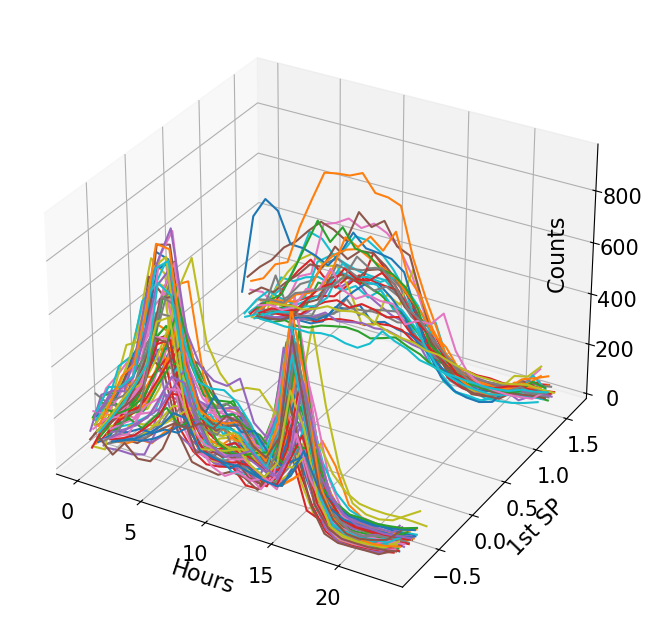

In [21]:
#beta_dcov = np.fliplr(beta_dcov)
num_rows = 100


selected_indices = np.random.choice(X.shape[0], num_rows, replace=False)

# Select the corresponding rows in X1 and Y
X1_selected = X[selected_indices, :]
Y_selected = Y[selected_indices, :]

X_b = X1_selected @ beta_dcov[:,0]
time  = np.linspace(23, 0, 24) 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot lines for each value in X
for i in range(len(X_b)):
    ax.plot( time,[X_b[i]] * len(time), Y_selected[i, :])  

# Set labels
ax.set_xlabel('Hours',fontsize=16)
ax.set_ylabel('1st SP',fontsize=16)
ax.text2D(0.87, 0.55, 'Counts', transform=ax.transAxes, fontsize=16, rotation=90)
# Increase the size of tick labels
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('bike1.png', dpi=300, bbox_inches='tight')
# Show plot
plt.show()


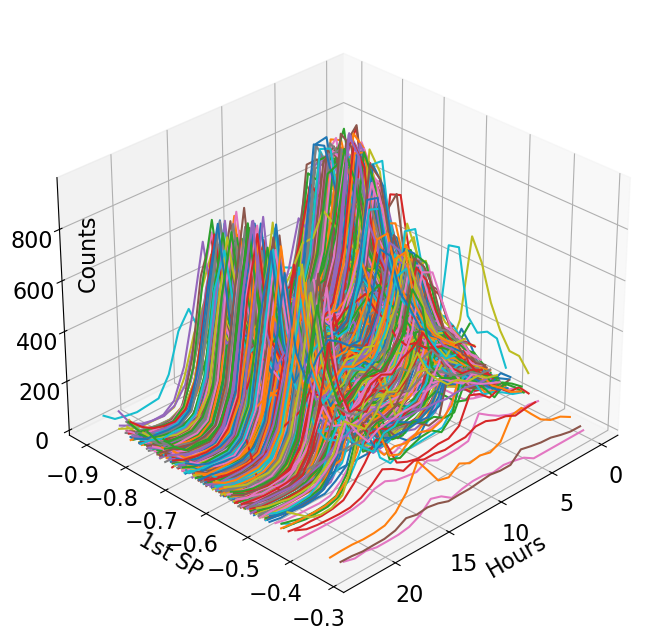

In [22]:
nonworkingday= pd.read_csv('nonworkingday.csv',header=None)
workingday = pd.read_csv('workingday.csv',header=None)
nonworkingday =nonworkingday.to_numpy()
workingday = workingday.to_numpy()
nonworkingday_indices = nonworkingday.flatten()-1
nonworkingday_X = X[nonworkingday_indices, :]
workingday_indices = workingday.flatten()-1
workingday_X = X[workingday_indices,:]
workingday_Y = Y[workingday_indices,:]
nonworkingday_Y = Y[nonworkingday_indices,:]

new_x1 = workingday_X @ beta_dcov[:,0]
new_x2 = nonworkingday_X @ beta_dcov[:,0]
Hours  = np.linspace(23, 0, 24) 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot lines for each value in X
for i in range(len(new_x1)):
    ax.plot( Hours,[new_x1[i]] * len(Hours), workingday_Y[i, :])  

# Set labels
ax.set_xlabel('Hours',fontsize=16)
ax.set_ylabel('1st SP',fontsize=16)
ax.text2D(0.08, 0.55, 'Counts', transform=ax.transAxes, fontsize=16, rotation=90)
# Increase the size of tick labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.view_init(elev=30, azim=45)
plt.savefig('bike2.png', dpi=300, bbox_inches='tight')
# Show plot
plt.show()


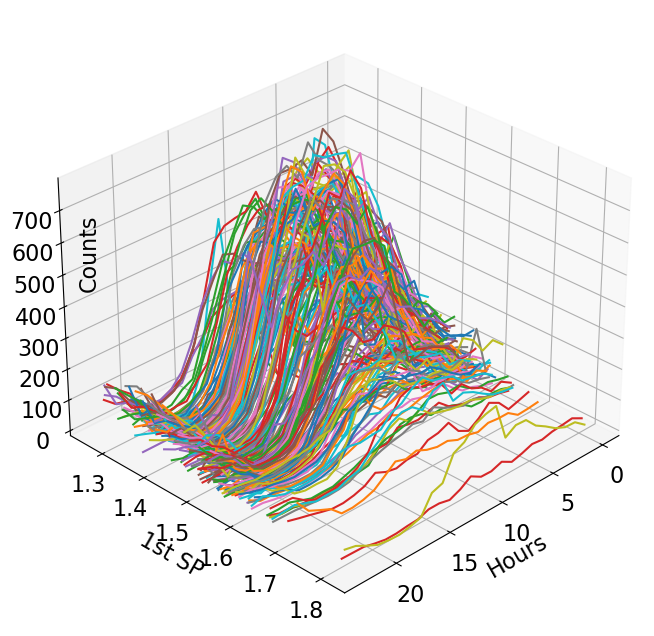

In [23]:

Hours  = np.linspace(23, 0, 24) 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot lines for each value in X
for i in range(len(new_x2)):
    ax.plot( Hours,[new_x2[i]] * len(Hours), nonworkingday_Y[i, :])  

# Set labels
ax.set_xlabel('Hours',fontsize=16)
ax.set_ylabel('1st SP',fontsize=16)
ax.text2D(0.08, 0.55, 'Counts', transform=ax.transAxes, fontsize=16, rotation=90)
ax.view_init(elev=30, azim=45)
# Increase the size of tick labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('bike3.png', dpi=300, bbox_inches='tight')
# Show plot
plt.show()

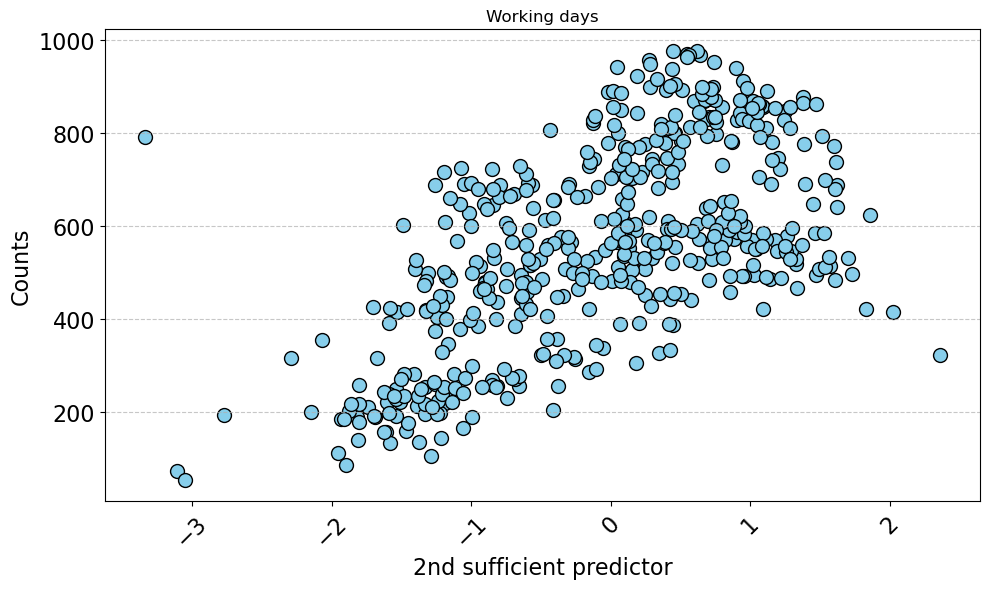

In [24]:
new_x12 = workingday_X @ beta_dcov[:,1]
new_x22 = nonworkingday_X @ beta_dcov[:,1]

max_working = np.max(workingday_Y,axis=1)
max_nonworking = np.max(nonworkingday_Y,axis =1)
plt.figure(figsize=(10, 6))  
plt.scatter(new_x12 ,max_working, color='skyblue', s=100, edgecolor='black') 
plt.xlabel('2nd sufficient predictor',fontsize=16)  
plt.ylabel('Counts',fontsize=16)  
# Increase the size of tick labels
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Working days') 
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  


plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.savefig('bike4.png', dpi=300, bbox_inches='tight')
plt.show()

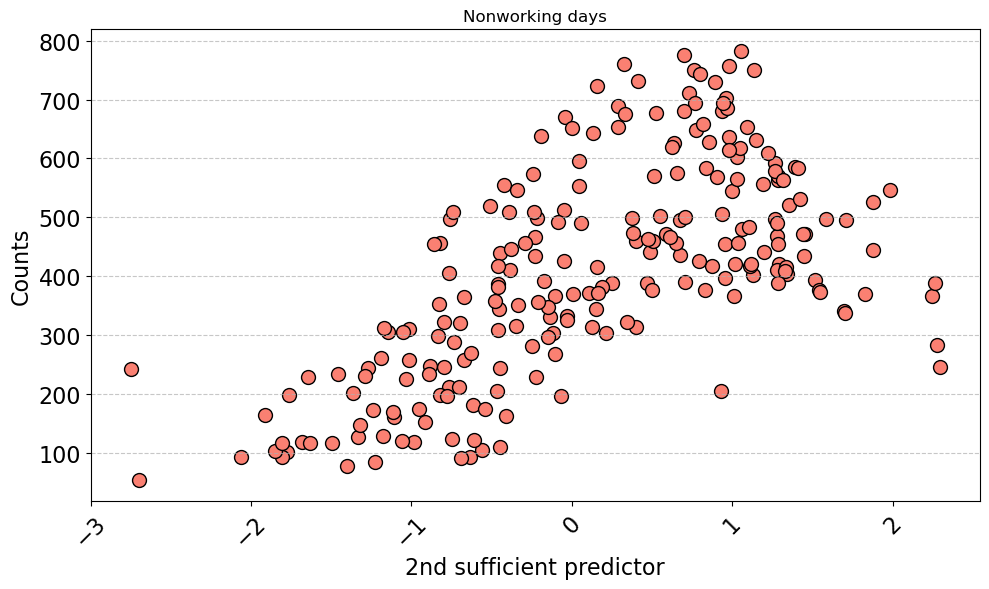

In [25]:
plt.figure(figsize=(10, 6))  
plt.scatter(new_x22 ,max_nonworking, color='salmon', s=100, edgecolor='black') 
plt.xlabel('2nd sufficient predictor',fontsize=16)  
plt.ylabel('Counts',fontsize=16)  
# Increase the size of tick labels
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Nonworking days') 
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  


plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.savefig('bike5.png', dpi=300, bbox_inches='tight')
plt.show()